In [1]:
from langchain_azure_ai.chat_models import AzureAIChatCompletionsModel
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END

from prompts import query_writer_instructions, summarizer_instructions, reflection_instructions, get_current_date, web_research_instructions
from formatting import deduplicate_and_format_sources, format_sources
from states import SummaryState, SummaryStateInput, SummaryStateOutput

from tavily import TavilyClient
from dotenv import load_dotenv
import os
import json

# Load environment variables from .env file
load_dotenv()


True

In [ ]:
# initialize deeep seek model
deep_seek_model = AzureAIChatCompletionsModel(
    endpoint="https://{resource_name}.services.ai.azure.com/models",
    credential= os.getenv("AZURE_AI_API_KEY"),
    model_name="DeepSeek-R1",
)

gpt_model = AzureAIChatCompletionsModel(
    endpoint="https://{resource_name}.services.ai.azure.com/models",
    credential= os.getenv("AZURE_AI_API_KEY"),
    model_name="gpt-4o",
)

images = []

#define helper function to seperate thinking from final response 
def strip_thinking_tokens(text: str):
    """
    Remove <think> and </think> tags and their content from the text.
    """
    while "<think>" in text and "</think>" in text:
        start = text.find("<think>")
        end = text.find("</think>") + len("</think>")
        thoughts = text[start:end]
        text = text[:start] + text[end:]
    return thoughts, text

# Nodes and Edges 

In [3]:
 # step 1: generate a query to search the web for the latest info
#use prompty here 
def generate_query(state: SummaryState):
    # Format the prompt
    current_date = get_current_date()
    formatted_prompt = query_writer_instructions.format(
        current_date=current_date,
        research_topic=state.research_topic
    )

    messages = [
        SystemMessage(content=formatted_prompt),
        HumanMessage(content=f"Generate a query for web search:"),
    ]
   
    response = gpt_model.invoke(messages)
    query = json.loads(response.content)
    search_query = query['query']
    print('query generated...')
    return {"search_query": search_query}

In [4]:
# step 2: look for that info online and get the results in a specific format
def web_research(state: SummaryState):

    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    search_results = tavily_client.search(state.search_query, 
                         max_results=1, 
                         max_tokens_per_source=1000,
                         include_raw_content=False,
                         include_images=True)
    for image in search_results['images']:
        images.append(image)
 
    # search_results = llm_with_tools.invoke(messages)
    search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000)
    print('web search completed...')
    return {"sources_gathered": [format_sources(search_results)], "research_loop_count": state.research_loop_count + 1, "web_research_results": [search_str]}

In [5]:
# step 3: summarize web research results.
# create or update a running summary based on the newest web research 
# integrating them with any existing summary. use with a prompty to pass system message 
def summarize_sources(state: SummaryState):
    print('summarizing...')
    # Existing summary
    existing_summary = state.running_summary

    # Most recent web research
    most_recent_web_research = state.web_research_results[-1]

    # Build the human message
    if existing_summary:
        human_message_content = (
            f"<Existing Summary> \n {existing_summary} \n <Existing Summary>\n\n"
            f"<New Context> \n {most_recent_web_research} \n <New Context>"
            f"Update the Existing Summary with the New Context on this topic: \n <User Input> \n {state.research_topic} \n <User Input>\n\n"
        )
    else:
        human_message_content = (
            f"<Context> \n {most_recent_web_research} \n <Context>"
            f"Create a Summary using the Context on this topic: \n <User Input> \n {state.research_topic} \n <User Input>\n\n"
        )


    messages = [
        SystemMessage(content=summarizer_instructions),
        HumanMessage(content=human_message_content)
    ]
    response = gpt_model.invoke(messages)
    running_summary = response.content
    
    return {"running_summary": running_summary}

In [9]:
# step 4: reflect of the summary and identify areas for further research and generates
# a new search query to address those gaps. Uses structured output to extract
#the follow-up query in JSON format. Use prompty here too

def reflect_on_summary(state: SummaryState):
    # Use the model to analyze the summary and decide whether to continue research or finalize it

    result = deep_seek_model.invoke(
        [SystemMessage(content=reflection_instructions.format(research_topic=state.research_topic)),
        HumanMessage(content=f"Reflect on our existing knowledge: \n === \n {state.running_summary}, \n === \n And now identify a knowledge gap and generate a follow-up web search query:")]
    )

    thoughts, text = strip_thinking_tokens(result.content)
    print(thoughts)
    try:
        # Try to parse as JSON first
        reflection_content = json.loads(text)
        # Get the follow-up query
        query = reflection_content.get('follow_up_query')
        # Check if query is None or empty
        if not query:
            # Use a fallback query
            return {"search_query": f"Tell me more about {state.research_topic}"}
        return {"search_query": query}
    except (json.JSONDecodeError, KeyError, AttributeError):
        # If parsing fails or the key is not found, use a fallback query
        return {"search_query": f"Tell me more about {state.research_topic}"}

In [7]:
# step 5: finalize the summary 
def finalize_summary(state: SummaryState):

    # Format the final summary with sources
    final_summary = f"## Summary\n{state.running_summary}\n\n### Sources:\n"
    for source in state.sources_gathered:
        final_summary += f"{source}\n"

    # state.running_summary = f"## Summary\n{state.running_summary}\n\n ### Sources:\n{unique_sources}"
    print('Done Researching...')
    return {"running_summary": final_summary}

In [6]:
#Conditional function (edge) that decided whether to continue the research
# of finalize the summary.
def route_research(state: SummaryState):
    if state.research_loop_count <= 3:
        print('researching more...')
        return "web_research"
    else:
        print('research complete...')
        return "finalize_summary"

In [11]:
# Add nodes and edges
builder = StateGraph(SummaryState, input=SummaryStateInput, output=SummaryStateOutput)
builder.add_node("generate_query", generate_query)
builder.add_node("web_research", web_research)
builder.add_node("summarize_sources", summarize_sources)
builder.add_node("reflect_on_summary", reflect_on_summary)
builder.add_node("finalize_summary", finalize_summary)

# Add edges
builder.add_edge(START, "generate_query")
builder.add_edge("generate_query", "web_research")
builder.add_edge("web_research", "summarize_sources")
builder.add_edge("summarize_sources", "reflect_on_summary")
builder.add_conditional_edges("reflect_on_summary", route_research)
builder.add_edge("finalize_summary", END)

graph = builder.compile()

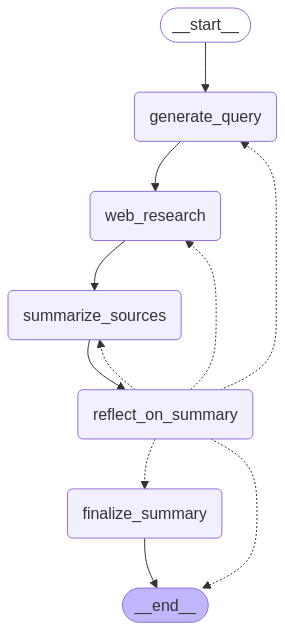

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"research_topic": user_input}):
        if event:
            if event.__contains__('generate_query'):
                print(event['generate_query'])
            elif event.__contains__('web_research'):
                print(event['web_research'])
            elif event.__contains__('finalize_summary'):
                print(event['finalize_summary']['running_summary'])

In [14]:
user_input="What are the best parks in London for the summer?"

stream_graph_updates(user_input)

query generated...
{'search_query': 'best parks in London to visit during summer 2025'}
web search completed...
{'sources_gathered': ['* Summer in London 2025: The Ultimate Guide to Events, Parks & Student Life : https://londonist.co.uk/blogs/summer-in-london-2025-the-ultimate-guide-to-events-parks-student-life'], 'research_loop_count': 1, 'web_research_results': ["Sources:\n\nSource: Summer in London 2025: The Ultimate Guide to Events, Parks & Student Life\n===\nURL: https://londonist.co.uk/blogs/summer-in-london-2025-the-ultimate-guide-to-events-parks-student-life\n===\nMost relevant content from source: Summer in London 2025: The Ultimate Guide to Events, Parks & Student Life Blog Detail Summer in London 2025: The Ultimate Guide to Events, Parks & Student Life Whether you're studying at a summer school, doing an internship, or just here for a vibey summer stay, we've got the ultimate guide to make London 2025 your best summer yet. British Summer Time Hyde Park (June-July 2025) – Liv